## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
def euclidean_distance(X, Y):
    return np.sqrt((X*X).sum(axis=1).reshape(-1, 1) + (Y*Y).sum(axis=1) - 2*X@Y.T)


def cosine_distance(X, Y):
    import numpy as np
    X_norm = np.sqrt((X*X).sum(axis=1).reshape(-1, 1))
    Y_norm = np.sqrt((Y*Y).sum(axis=1))
    X_norm[X_norm == 0] = 0.001
    Y_norm[Y_norm == 0] = 0.001
    return 1 - ((X@Y.T) / (X_norm * Y_norm))

In [3]:
from sklearn.neighbors import NearestNeighbors, KDTree

In [4]:
class MyKNeighborsClassifier(BaseEstimator):
    def __init__(self, n_neighbors, algorithm='my_own', metric='euclidean', weights=False):
        self.k = n_neighbors
        self.strategy = algorithm
        self.metric = metric
        self.weights = weights
        self.X_train = None
        self.y_train = None
        if algorithm != 'my_own' and algorithm != 'brute' and algorithm != 'kd_tree' and algorithm != 'ball_tree':
            raise TypeError("Not right arguments for 'strategy'")
        if metric != 'euclidean' and metric != 'cosine':
            raise TypeError("Not right arguments for 'metric'")
        if algorithm == 'my_own' or algorithm == 'kd_tree':
            self.strat_class = None
        elif self.metric == 'cosine' and (self.strategy == 'kd_tree' or self.strategy == 'ball_tree'):
            raise TypeError("Not right metric for strategy")
        else:
            self.strat_class = NearestNeighbors(n_neighbors=self.k, algorithm=algorithm, metric=metric)

    def find_kneighbors(self, X, return_distance=True):
        if self.X_train is None:
            raise TypeError("This KNNClassifier instance is not fitted yet")
        if self.strategy == 'my_own':
            if self.metric == 'euclidean':
                Distances = euclidean_distance(X, self.X_train)
            else:
                Distances = cosine_distance(X, self.X_train)
            Idx = np.argsort(Distances, axis=1)[..., :self.k]
            Distances = np.sort(Distances, axis=1)[..., :self.k]
            if return_distance is True:
                return (Distances, Idx)
            else:
                return Idx
        elif self.strategy == 'kd_tree':
            return self.strat_class.query(X, self.k, return_distance=return_distance)
        else:
            return self.strat_class.kneighbors(X, self.k, return_distance=return_distance)

    def fit(self, X, y):
        self.X_train = np.copy(X)
        self.y_train = np.copy(y)
        if self.strategy == 'kd_tree':
            self.strat_class = KDTree(X)
        elif self.strategy != 'my_own':
            self.strat_class.fit(self.X_train)
            

    def predict(self, X):
        y_pred = np.array([])
        eps = 1e-5

        if self.weights:
            weights, neighbors = self.find_kneighbors(X, return_distance=True)
            weights = 1/(weights + eps)
            classes = self.y_train[neighbors]
            if self.k == 1:
                y_pred = np.append(y_pred, classes)
            else:
                dist = np.zeros(len(np.unique(self.y_train)))
                for j in range(len(classes)):
                    for cl in range(len(np.unique(self.y_train))):
                        dist[cl] = weights[j][classes[j] == cl].sum()
                    idx = np.argmax(weights, axis=1)
                    y_pred = np.append(y_pred, np.argmax(dist))
                    dist[:] = 0
        else:
            neighbors = self.find_kneighbors(X, return_distance=False)
            for n in neighbors:
                classes = self.y_train[n]
                if self.k == 1:
                    y_pred = np.append(y_pred, classes)
                else:
                    classes_count = np.bincount(classes)
                    y_pred = np.append(y_pred, np.argmax(classes_count))
        return y_pred

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [5]:
iris = datasets.load_iris()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [7]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='my_own')

In [8]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [9]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [11]:
%time clf.fit(X_train, y_train)

Wall time: 999 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [12]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [13]:
%time clf.predict(X_test)

Wall time: 3 ms


array([0, 2, 0, 0, 1, 1, 1, 2, 2, 1, 0, 0, 2, 2, 1])

In [14]:
%time my_clf.predict(X_test)

Wall time: 1 ms


array([0., 2., 0., 0., 1., 1., 1., 2., 2., 1., 0., 0., 2., 2., 1.])

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [15]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [17]:
%time clf.fit(X_train, y_train)

Wall time: 22.5 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [18]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [19]:
%time clf.predict(X_test)

Wall time: 4.95 ms


array([0, 2, 1, 0, 0, 2, 1, 0, 1, 2, 0, 1, 2, 1, 1])

In [20]:
%time my_clf.predict(X_test)

Wall time: 998 µs


array([0., 2., 1., 0., 0., 2., 1., 0., 1., 2., 0., 1., 2., 1., 1.])

In [21]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [22]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [23]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [25]:
count_vec = CountVectorizer(max_df=0.8, min_df=10, stop_words='english')
tf_idf = TfidfVectorizer(max_df=0.8, min_df=10, stop_words='english')

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [14]:
def kfold_split(num_objects, num_folds):
    """Split [0, 1, ..., num_objects - 1] into equal num_folds folds (last fold can be longer) and returns num_folds train-val 
       pairs of indexes.

    Parameters:
    num_objects (int): number of objects in train set
    num_folds (int): number of folds for cross-validation split

    Returns:
    list((tuple(np.array, np.array))): list of length num_folds, where i-th element of list contains tuple of 2 numpy arrays,
                                       the 1st numpy array contains all indexes without i-th fold while the 2nd one contains
                                       i-th fold
    """
    folds = []
    num_test = num_objects // num_folds
    last_test_idx = 0
    all_idx = np.arange(num_objects)
    for i in range(num_folds - 1):
        test_idx = all_idx[last_test_idx:last_test_idx + num_test]
        train_idx = np.delete(all_idx, test_idx)
        folds += [(train_idx, test_idx)]
        last_test_idx = last_test_idx + num_test
    test_last = all_idx[last_test_idx:num_objects]
    folds += [(np.delete(all_idx, test_last), test_last)]
    return folds

In [15]:
def knn_cv_score(X, y, parameters, score_function, folds, knn_class):
    """Takes train data, counts cross-validation score over grid of parameters (all possible parameters combinations) 

    Parameters:
    X (2d np.array): train set
    y (1d np.array): train labels
    parameters (dict): dict with keys from {n_neighbors, metrics, weights, normalizers}, values of type list,
                       parameters['normalizers'] contains tuples (normalizer, normalizer_name), see parameters
                       example in your jupyter notebook
    score_function (callable): function with input (y_predict, y_true) which outputs score metric
    folds (list): output of kfold_split
    knn_class (obj): class of knn model to fit

    Returns:
    dict: key - tuple of (normalizer_name, n_neighbors, metric, weight), value - mean score over all folds
    """
    if folds is None:
        folds = kfold_split(X.shape[0], 3)
    res = {}
    n_neighbors = parameters['n_neighbors']
    metrics = parameters['metrics']
    weights = parameters['weights']
    normalizers = parameters['normalizers']
    for k in n_neighbors:
        for metric in metrics:
            for w in weights:
                for norm in normalizers:
                    cv_score = []
                    for cv in folds:
                        train_folds, test_folds = cv[0], cv[1]
                        X_train, y_train = X[train_folds], y[train_folds]
                        X_test, y_test = X[test_folds], y[test_folds]
                        if norm[0] is not None:
                            norm[0].fit(X_train)
                            X_train = norm[0].transform(X_train)
                            X_test = norm[0].transform(X_test)
                        clf = knn_class(n_neighbors=k, weights=w, metric=metric)
                        clf.fit(X_train, y_train)
                        y_pred = clf.predict(X_test)
                        cv_score.append(score_function(y_test, y_pred))
                    key = (norm[1], k, metric, w)
                    res[key] = np.mean(cv_score)
    return res

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [18]:
parameters = {
    'n_neighbors': [i for i in range(1, 11)],
    'metrics': ['euclidean', 'cosine'],
    'weights': ['uniform'],
    'normalizers': [(count_vec, 'CountVectorizer'), (tf_idf, 'TfidfVectorizer')]
}

In [19]:
folds = kfold_split(np.array(data).shape[0], 3)
out = knn_cv_score(np.array(data), np.array(target), parameters, accuracy_score, folds, KNeighborsClassifier)

In [23]:
acc_cnt_euc, acc_cnt_cos, acc_tf_euc, acc_tf_cos = [], [], [], []
for k in out.keys():
    if k[0] == 'CountVectorizer':
        if k[2] == 'euclidean':
            acc_cnt_euc.append(out[k])
        else:
            acc_cnt_cos.append(out[k])
    elif k[2] == 'euclidean':
        acc_tf_euc.append(out[k])
    else:
        acc_tf_cos.append(out[k])

In [26]:
def plot(x, y, labels, title, xlabel):
    plt.figure(figsize=(13,7))

    for acc, label in zip(y, labels):
        plt.plot(x, acc, label=label)
    
    plt.title(title, fontsize=15)
    plt.grid(True)
    plt.ylabel("Accuracy",  fontsize=15)
    plt.xlabel(xlabel,  fontsize=15)
    plt.legend(fontsize=15)

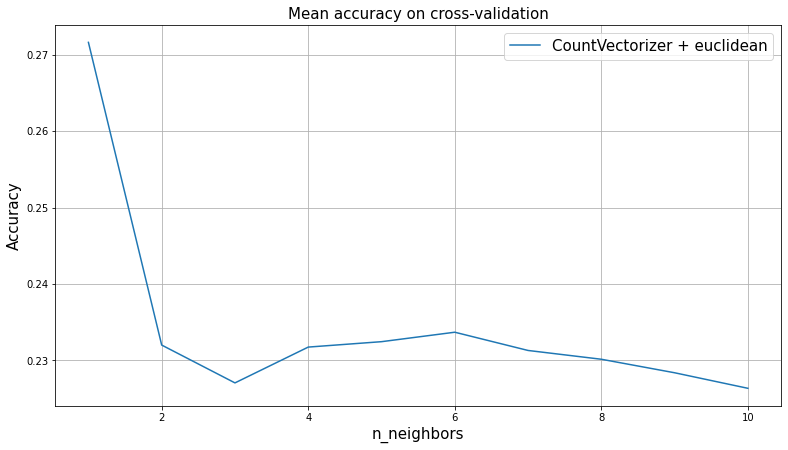

In [28]:
title = 'Mean accuracy on cross-validation'
label1 = 'CountVectorizer + euclidean'
label2 = 'CountVectorizer + cosine'
label3 = 'TfidfVectorizer + euclidean'
label4 = 'TfidfVectorizer + cosine'
plot(range(1, 11), [acc_cnt_euc], [label1], title, 'n_neighbors')

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

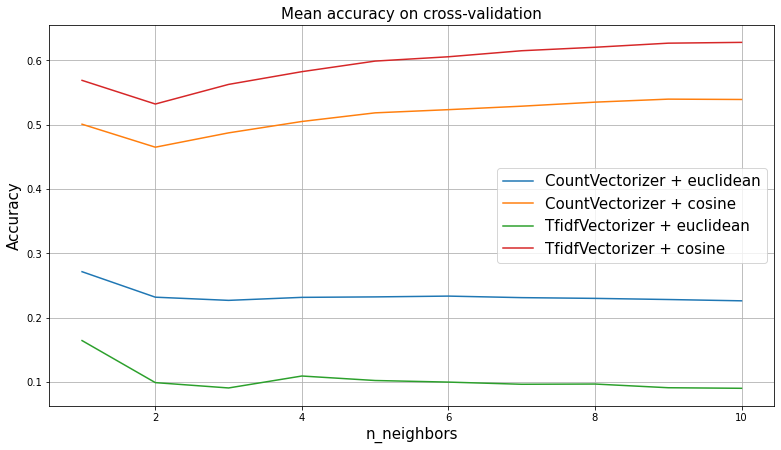

In [29]:
plot(range(1, 11), [acc_cnt_euc, acc_cnt_cos, acc_tf_euc, acc_tf_cos], [label1, label2, label3, label4], title, 'n_neighbors')

Видим, что наилучшее качество показал TfidfVectorizer + cosine с 10 соседями

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [26]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [28]:
data_test = newsgroups['data']
target_test = newsgroups['target']

data_train_tf = tf_idf.fit_transform(data)
data_test_tf = tf_idf.transform(data_test)

knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
knn.fit(data_train_tf, target)

target_pred = knn.predict(data_test_tf)
accuracy_score(target_pred, target_test)

0.580987785448752